In [1]:
""" 
Ordered response + PCA
"""

' \nOrdered response + PCA\n'

Motivation

* Female and male body status may be related to different features, hence may be related to different embedding axes. The embedding axes may change order for males and females. In this simulation, we assume the embedding axis 1 for females corresponds to the embedding axis 2 for males, and the embedding axis 2 for males corresponds to the embedding axis 1 for females.

* Using the model trained by males, does transporting female embedding onto male embedding help with female predictinons?

Simulation

* Suppose the embedding dimension is 2.

* $r$ for indexing domains

* Let $N$ be the total number of training data, $N_{s}$ be the number of data in the source domain, $N_{t}$ be the number of data in the target domain. $N'$ be the number of test data.

* Sample $\beta_{s1} = \beta_{t2} \sim \operatorname{Gaussian}\left(0,1\right)$, $\beta_{s2} = \beta_{t1} \sim \operatorname{Gaussian}\left(50,1\right)$

* Pick function $g$ from sigmoid, identify function, natural log function. 

* Simulate $X_s  = [X_{s1}, X_{s2}] \sim \operatorname{MVN}\left(\mu_s, \Sigma_s\right)$

* Simulate $Y_s = \beta_{s1} X_{s1} + \beta_{s2} X_{s2} + \epsilon$

* Simulate $X_t  = [X_{t1}, X_{t2}] \sim \operatorname{MVN}\left(\mu_t, \Sigma_t\right)$

* Simulate $Y_t = \beta_{t1} X_{t1} + \beta_{t2} X_{t2} + \epsilon$


Expectation:

* After transportation, axis 1 in the source embedding space corresponds to axis 2 in the target embedding space, and axis 2 in the source embedding space corresponds to axis 1 in the target embedding space.

* Tranporting source embedding onto target embedding space helps with source data prediction using the model trained by target data.



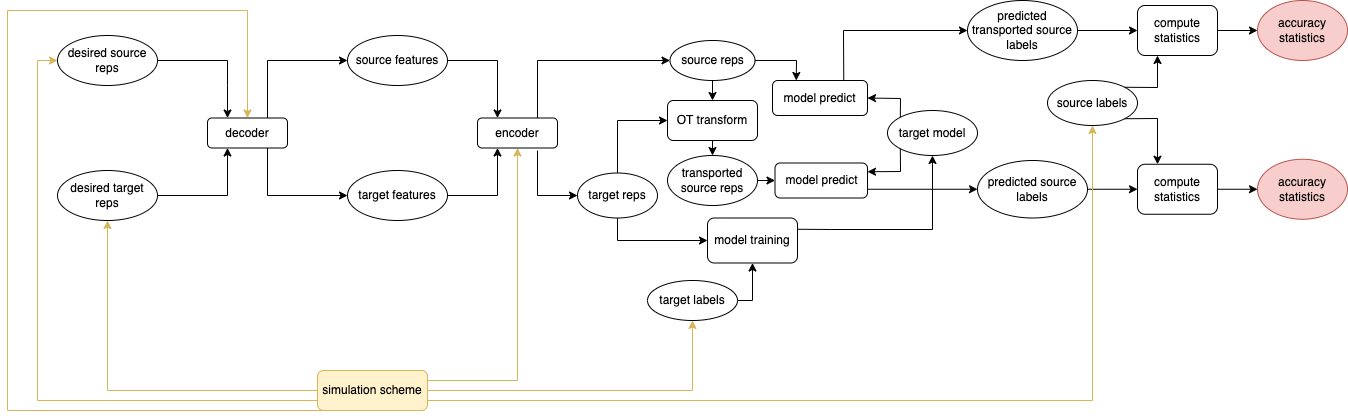

In [2]:
from IPython.display import Image
Image(filename='../outputs/pipeline_figs/EHR_emb_sim_pipeline.png')

In [3]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
from deep_patient.sda import SDA
from math import floor, exp
import matplotlib.pylab as pl
import numpy as np
from numpy.random import normal
from numpy.random import poisson
from numpy.random import dirichlet
import os
import ot
import ot.plot
from random import randint
import theano.tensor as T
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/synthetic")


In [5]:
def simulate_emb_label(mu, sigma, beta_1, beta_2, num_points, num_features, nz=.5, theta=0, p=.5, random_state=None, **kwargs):
    """ Simulate desired embeddings and labels
 
    Parameters
    ----------
    mu : list[float], size 2 (for embedding dimension 2)
        mean of MVN
    sigma : list[float], size 2
        standard deviation of MVN
    num_points: int
        number of points generated
    nz : float
        noise level (>0)
    p : float
        proportion of one class in the binary setting
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (n, d), the desired embedding
        `n` observation of size `d`
    y : ndarray, shape (n,), the labels
        labels of the samples.
    """
    
    generator = check_random_state(random_state)
    
    x_1 = normal(mu[0], sigma[0], size=num_points)
    x_2 = normal(mu[1], sigma[1], size=num_points)
    x = np.column_stack((x_1, x_2))
    y = [x_1_elem * beta_1 + x_2_elem * beta_2 + nz * generator.randn(len(x_1), 1)[0] for x_1_elem, x_2_elem in zip(x_1, x_2)]

    new_x = []
    ori_dim = 2
    for i in range(x.shape[0]):
        cur_x = x[i].tolist()
        cur_x.extend(normal(0, 0.01, num_features-ori_dim))
        new_x.append(cur_x)


    return np.array(new_x), np.array(y)

In [6]:
""" 
Simulation scheme
"""

def simulate_pca_train(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2, for PCA training
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme

    TODO: reconsider the choice of alpha_1 and alpha_2

    :return
        list[list[int]] domain 1 features
        list[int] domain 1 labels
        list[list[int]] domain 2 features
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    delta_1 = np.random.choice(size = d_1, a = range(1, D+1), replace=False)
    remaining_set = list(set(list(range(1, D+1)))-set(delta_1))
    delta_2 = np.random.choice(size = d_1, a = remaining_set, replace=False)
    
    unit_1 = 1/(2*d_1-2*d_2+3*D)
    alpha_1 = [5*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([3*unit_1]*(D-d_1-d_2))
  
    unit_2 = 1/(-2*d_1+2*d_2+3*D)
    alpha_2 = [unit_2]*d_1
    alpha_2.extend([5*unit_2]*d_2)
    alpha_2.extend([3*unit_2]*(D-d_1-d_2))  
    W = np.random.normal(size=D)
    W  = [abs(W_k) for W_k in W] # only sample positive weights

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]

        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(len(rho), rho)
            # for k in range(len(X_i)):
            #     if X_i[k] > 0:
            #         X_i[k] = 1 # dominant effect
            X.append(X_i)
            cur_sum = np.sum(np.multiply(W, X_i))
            all_sum.append(cur_sum)
        
        # print("all_sum before preprocessing is:", all_sum)
        # standardize
        all_sum = preprocessing.scale(all_sum)
        # print("all_sum after preprocessing is:", all_sum)

        all_sum = np.array(all_sum)
        
        P = []
        for cur_sum in all_sum:
            p_i = sigmoid(cur_sum)
            P.append(p_i)
            Y_i = 0
            if p_i >= 0.5: # TODO: mimic exact logistic regression, change to np.random.binomial later
                Y_i = 1
            # Y_i = np.random.binomial(1, p_i) # too much noise, domain 1 data cannot learn well
            Y.append(int(Y_i))
        # print("P is:", P)

            
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    
    def pad_features(features_list):
        """ 
        Pad features to the same length (maximum length of the original features)\
            in each domain by -1
        """
        max_len = 0
        for features in features_list:
            max_len = max(max_len, len(features))

        for i in range(len(features_list)):
            features_list[i] += [-1] * (max_len - len(features_list[i]))
        return features_list



    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    # feature_1 = pad_features(feature_vector_to_feature(feature_vector_1))
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    # feature_2 = pad_features(feature_vector_to_feature(feature_vector_2))
    return np.array(feature_vector_1), label_1, np.array(feature_vector_2), label_2



In [7]:
""" 
Wrapper function with different set ups for simulate()
"""
def simulate_pca_train_wrapper():
    num_patient = 1000
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate_pca_train(D, d_1, d_2, num_patient)

In [8]:
def simulate_desired_emb_labels(num_patient, num_features):
    """ 
    Simulate target and source desired embedding space and labels
    """
    train_target_features, train_target_labels, _, _ = simulate_pca_train_wrapper()
    global pca
    pca = PCA(n_components=num_features)
    pca.fit(train_target_features)
    source_mu = [4, 1]
    source_sigma = [1, 0.5]
    target_mu = [0.5, 2]
    target_sigma = [0.5, 1]
    beta_1 = 0.5
    beta_2 = 10
    source_desired_reps, source_labels = simulate_emb_label(source_mu, source_sigma, beta_1, beta_2, num_patient, num_features)
    target_desired_reps, target_labels = simulate_emb_label(target_mu, target_sigma, beta_2, beta_1, num_patient, num_features)

    return target_desired_reps, target_labels, source_desired_reps, source_labels


In [9]:
def feature_vector2_feature(feature_vector):
    return [i for i, e in enumerate(feature_vector) if e > 0]

def feature_vector2_features(feature_vectors):
    ret = []
    for feature_vector in feature_vectors:
        ret.append([i for i, e in enumerate(feature_vector) if e > 0])
    return ret

In [10]:
def simulate(num_patient, num_features):
    """ 
    Simulate target features, target labels, source features and source labels
    """
    
    target_desired_reps, target_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(num_patient, num_features)
    
    target_feature_vectors = pca.inverse_transform(target_desired_reps)
    target_feature_vectors = [[int(code) for code in inner] for inner in target_feature_vectors]
    source_feature_vectors = pca.inverse_transform(source_desired_reps)
    source_feature_vectors = [[int(code) for code in inner] for inner in source_feature_vectors]
    return target_feature_vectors, target_labels, source_feature_vectors, source_labels



In [11]:
def simulate_wrapper():
    num_patient = 1000
    num_features = 20
    return simulate(num_patient, num_features=num_features)

In [12]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_feature_vectors, source_feature_vectors):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations
    """
    global pca
    target_reps = pca.transform(target_feature_vectors)
    source_reps = pca.transform(source_feature_vectors)

    return target_reps, source_reps


In [13]:
""" 
One run of the experiment
"""
num_patient = 100
num_features = 20
target_desired_reps, target_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(num_patient, num_features)
ot_emd = ot.da.SinkhornTransport(reg_e=1e-1)
ot_emd.fit(Xs=source_desired_reps, Xt=target_desired_reps)
trans_source_desired_reps = ot_emd.transform(Xs=source_desired_reps)


In [14]:
# """ 
# Visualize the desired embedding space
# """
# plt.figure(1, figsize=(18, 5))

# plt.subplot(1, 4, 1)
# plt.scatter(source_desired_reps[:, 0], source_desired_reps[:, 1], c="cornflowerblue")
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.title("(a) Target embedding", loc='left', fontweight='bold', fontsize=20)

# plt.subplot(1, 4, 2)
# plt.scatter(target_desired_reps[:, 0], target_desired_reps[:, 1], c="orange")
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.title("(b) Source embedding",  loc='left', fontweight='bold', fontsize=20)

# plt.subplot(1, 4, 3)
# plt.scatter(trans_source_desired_reps[:, 0], trans_source_desired_reps[:, 1], c="green")
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.title("(c) Transported \n target embedding",  loc='left', fontweight='bold', fontsize=20)

# plt.subplot(1, 4, 4)
# plt.scatter(source_desired_reps[:, 0], source_desired_reps[:, 1], c="cornflowerblue", label="target")
# plt.scatter(target_desired_reps[:, 0], target_desired_reps[:, 1], c="orange", label="source")
# plt.scatter(trans_source_desired_reps[:, 0], trans_source_desired_reps[:, 1],  c="green", label="trans target")
# ot.plot.plot2D_samples_mat(source_desired_reps, target_desired_reps, ot_emd.coupling_, c=[.5, .5, 1])
# plt.legend(fontsize=17)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.title("(d) Superimposing",  loc='left', fontweight='bold', fontsize=20)

# fig_path = os.path.join(output_dir, "sim9_desired_emb.pdf")
# plt.tight_layout()
# plt.savefig(fig_path, bbox_inches='tight')
# plt.show()

In [15]:
target_features = pca.inverse_transform(target_desired_reps)
target_features = [[int(code) for code in inner] for inner in target_features]
source_features = pca.inverse_transform(source_desired_reps)
source_features = [[int(code) for code in inner] for inner in source_features]
source_reps = pca.transform(source_features)
target_reps, source_reps = custom_train_reps(target_features, source_features)

ot_emd = ot.da.SinkhornTransport(reg_e=1e-1)
ot_emd.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_emd.transform(Xs=source_reps)


/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


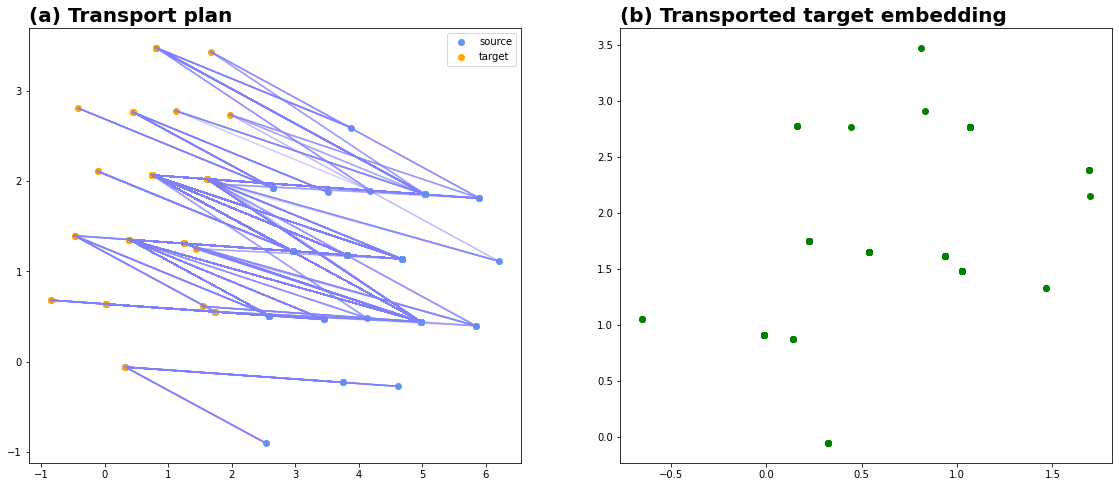

In [16]:
""" 
Visualize the actual feature in 2D
"""
textsize = 20
plt.figure(1, figsize=(30, 8))
# pl.subplot(1, 4, 1)
# pl.scatter(source_reps[:, 0], source_reps[:, 1], c="cornflowerblue")
# pl.title("(a) Target embedding", fontweight='bold', loc='left', fontsize=15)

# pl.subplot(1, 4, 2)
# pl.scatter(target_reps[:, 0], target_reps[:, 1], c="orange")
# pl.title("(b) Source embedding", fontweight='bold', loc='left')

# pl.subplot(1, 4, 3)
# pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c="green")
# pl.title("(c) Transported target embedding", fontweight='bold', loc='left')

plt.subplot(1, 3, 1)
plt.scatter(source_reps[:, 0], source_reps[:, 1], c="cornflowerblue", label="source")
plt.scatter(target_reps[:, 0], target_reps[:, 1], c="orange", label="target")
# plt.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1],  c="green", label="trans source")
ot.plot.plot2D_samples_mat(source_reps, target_reps, ot_emd.coupling_, c=[.5, .5, 1])
plt.legend()
plt.title("(a) Transport plan", fontweight='bold', loc='left', fontsize=textsize)

plt.subplot(1, 3, 2)
plt.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c="green")
plt.title("(b) Transported target embedding", fontweight='bold', loc='left', fontsize=textsize)

plt.show()

In [17]:
""" 
Calculate accuracy statistics
"""
target_mae, target_mse, target_rmse, source_mae, source_mse, source_rmse,\
    trans_source_mae, trans_source_mse, trans_source_rmse = \
    cal_stats_cts(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps, linear_model.LinearRegression)

print("source mae is:", source_mae, "source rmse is:", source_rmse)
print("trans source mae is:", trans_source_mae, "trans source rmse is:", trans_source_rmse)

source mae is: 21.45364157703302 source rmse is: 22.811523072051564
trans source mae is: 6.409538794121915 trans source rmse is: 7.5907843577706


In [18]:
""" 
Multiple runs
"""
entire_proc_cts(simulate_wrapper, custom_train_reps, linear_model.LinearRegression, max_iter = 100000)


(2.0185604726475463,
 6.28910139324157,
 2.507808085408764,
 21.49919525948229,
 537.5067730089522,
 23.184192308746756,
 6.720870287032479,
 66.31719281452902,
 8.14353687377475)

In [19]:
target_maes, target_mses, target_rmses,  source_maes, source_mses, source_rmses, \
    trans_source_maes, trans_source_mses, trans_source_rmses = \
    run_proc_multi_cts(simulate_wrapper, custom_train_reps, linear_model.LinearRegression, max_iter = 100000, n_times = 100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


In [25]:
score_path = "../outputs/synthetic/sim9_lr_scores.csv"
save_scores_cts(target_maes, target_mses, target_rmses,  source_maes, source_mses, source_rmses, \
        trans_source_maes, trans_source_mses, trans_source_rmses, score_path)

average trans source to source mae is 32.8%
median trans source to source mae is 34.8%
average trans source to source rmse is 36.3%
median trans source to source rmse f1 is 38.4%


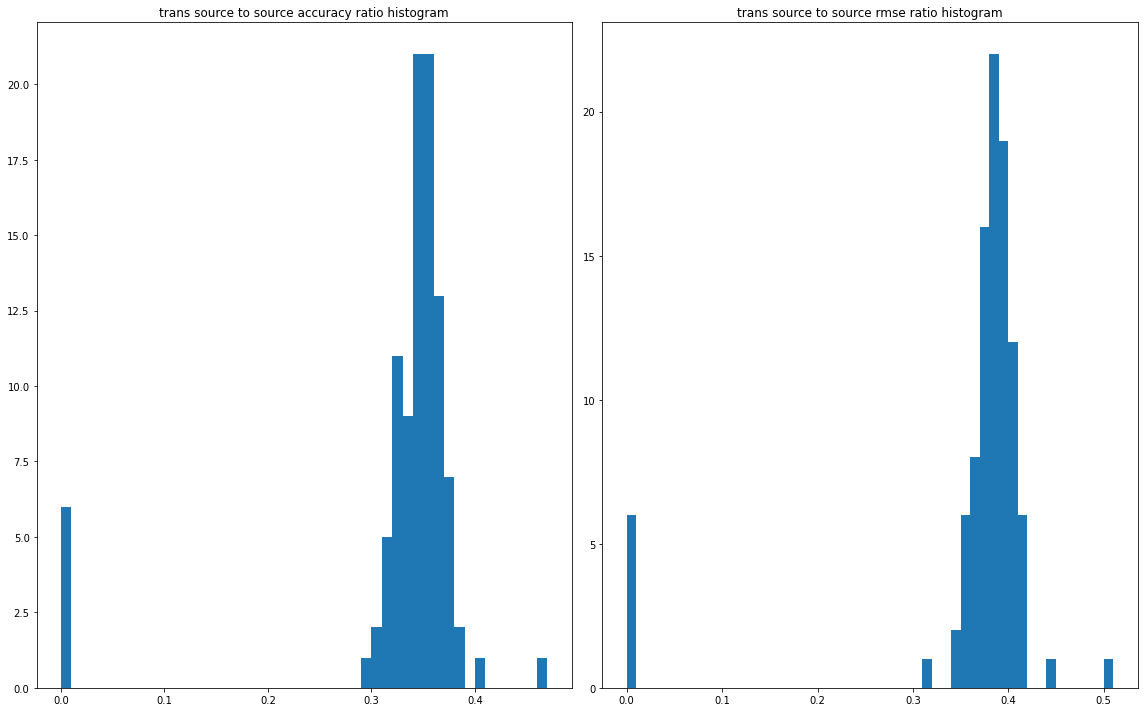

In [26]:
""" 
Plot the histogram (bigger is better, > 0)
"""

hist_plot_cts(score_path)

<Figure size 432x288 with 0 Axes>

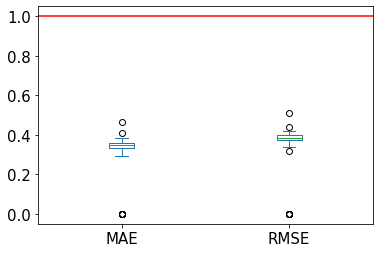

(0.34770060991451224, 0.38426671567858084)

In [27]:
score_path = "../outputs/synthetic/sim9_lr_scores.csv"
save_path = "../outputs/synthetic/sim9_res.png"
box_plot_cts_short(score_path, save_path)

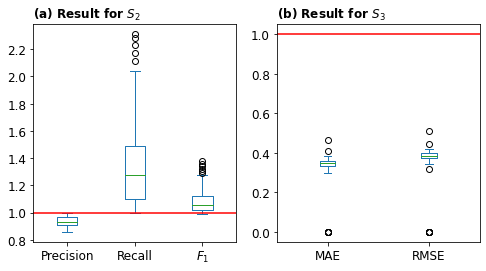

In [23]:
""" 
Combine sim9 and sim 7 box plot into one plot
"""
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)

score_path = "../outputs/synthetic/sim7_svm_scores.csv"

scores_df = pd.read_csv(score_path, index_col=None, header=0)

target_precision = scores_df['target_precision']
target_recall = scores_df['target_recall']
target_f1 = scores_df['target_f1']

source_precision = scores_df['source_precision']
source_recall = scores_df['source_recall']
source_f1 = scores_df['source_f1']

trans_source_precision = scores_df['trans_source_precision']
trans_source_recall = scores_df['trans_source_recall']
trans_source_f1 = scores_df['trans_source_f1']

# source to target precision
source_target_precision = [i / j for i, j in zip(source_precision, target_precision)]

# transported source to target precision
trans_source_target_precision = [i / j for i, j in zip(trans_source_precision, target_precision)]

# transported source to source precision
trans_source_source_precision = [i / j for i, j in zip(trans_source_precision, source_precision)]

# source to target recall
source_target_recall = [i / j for i, j in zip(source_recall, target_recall)]

# transported source to target recall
trans_source_target_recall = [i / j for i, j in zip(trans_source_recall, target_recall)]

# transported source to source recall
trans_source_source_recall = [i / j for i, j in zip(trans_source_recall, source_recall)]

# transported source to source f1
trans_source_source_f1 = [i / j for i, j in zip(trans_source_f1, source_f1)]

# Pandas dataframe
data = pd.DataFrame({
    'Precision': trans_source_source_precision,
    'Recall': trans_source_source_recall,
    r'$F_1$': trans_source_source_f1
})

# Plot the dataframe
ax = data[['Precision', 'Recall', r'$F_1$']].plot(kind='box', ax=axes[0])
ax.tick_params(labelsize=12)
ax.set_title(r"(a) Result for $S_2$", fontweight='bold', loc='left')

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

# plot the second figure

def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

score_path = "../outputs/synthetic/sim9_lr_scores.csv"

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]

# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[1])
ax.tick_params(labelsize=12)
ax.set_title(r"(b) Result for $S_3$", fontweight='bold', loc='left')


# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

save_path = os.path.join(output_dir, "sim7_sim9_res.pdf")
plt.savefig(save_path, bbox_inches='tight')

plt.show()
    

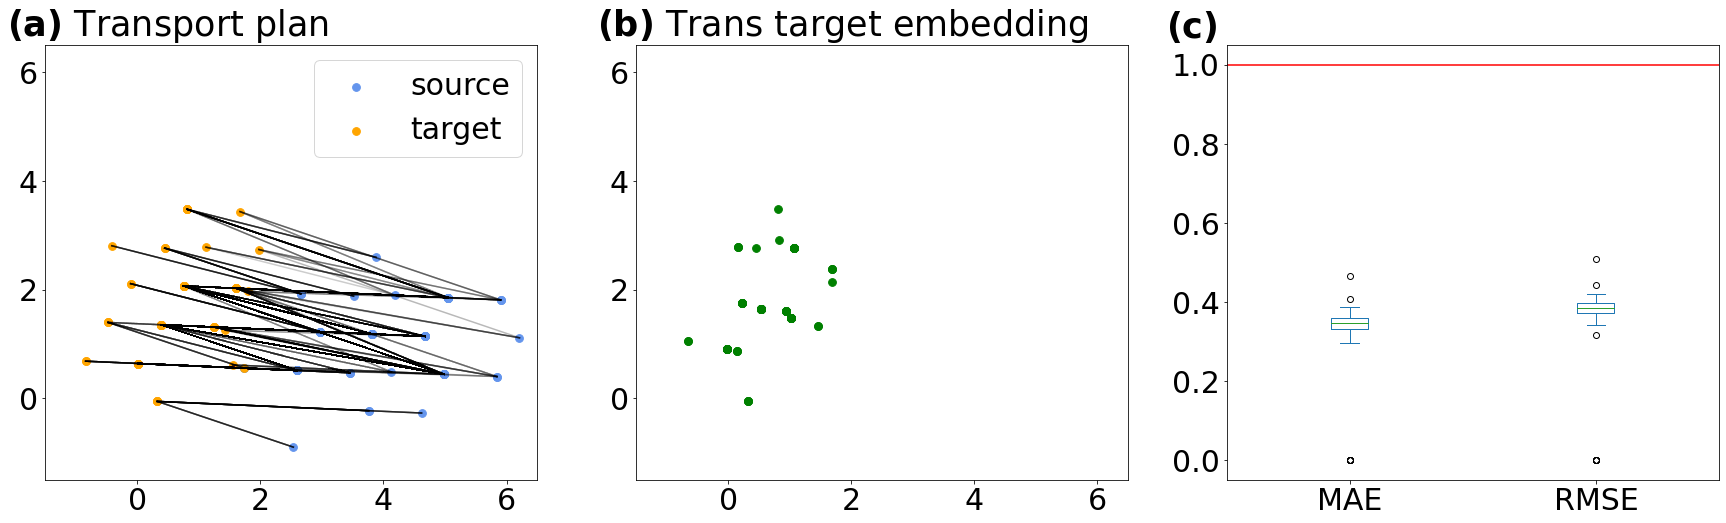

In [30]:
""" 
Visualize the actual feature in 2D
"""
text_size = 30
title_size=35
plt.figure(1, figsize=(30, 8))

plt.subplot(1, 3, 1)
plt.scatter(source_reps[:, 0], source_reps[:, 1], c="cornflowerblue", label="source", s=60)
plt.scatter(target_reps[:, 0], target_reps[:, 1], c="orange", label="target", s=60)
plt.xlim(-1.5, 6.5)
plt.ylim(-1.5, 6.5)
plt.tick_params(labelsize=text_size)
ot.plot.plot2D_samples_mat(source_reps, target_reps, ot_emd.coupling_, c='black', alpha=0.5)
plt.legend(fontsize=text_size)
plt.title(r"$\bf{(a)}$ Transport plan", x=0.25, fontsize=title_size)

plt.subplot(1, 3, 2)
plt.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c="green", s=60)
plt.xlim(-1.5, 6.5)
plt.ylim(-1.5, 6.5)
plt.tick_params(labelsize=text_size)
plt.title(r'$\bf{(b)}$ Trans target embedding', x=0.42, fontsize=title_size)

ax3 = plt.subplot(1, 3, 3)
score_path = "../outputs/synthetic/sim9_lr_scores.csv"

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]

# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=ax3)
ax.tick_params(labelsize=text_size)
ax.set_title(r"$\bf{(c)}$", x=-0.07, fontsize=title_size)

ax.tick_params(labelsize=text_size)

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

save_path = os.path.join(output_dir, "sim9_res.pdf")
plt.savefig(save_path, bbox_inches='tight')

plt.show()